In [1]:
import sys
sys.path.append('..')
import pandas as pd
from adat.models.classification_model import LogisticRegressionOnTfIdf
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
train_data = pd.read_csv('../data/insurance/train.csv')
test_data = pd.read_csv('../data/insurance/test.csv')

In [32]:
train_data = pd.read_csv('../data/ai_academy_data/train.csv')
test_data = pd.read_csv('../data/ai_academy_data/test.csv')

In [33]:
train_x = train_data.sequences.values
train_y = train_data.labels.values

test_x = test_data.sequences.values
test_y = test_data.labels.values

In [34]:
model = LogisticRegressionOnTfIdf()

In [35]:
model.fit(train_x, train_y)

In [36]:
probs = model.predict(test_x)

In [112]:
auc = roc_auc_score(y_true=test_y, y_score=probs, multi_class='ovr')
print(f'ROC AUC = {auc}')

ROC AUC = 0.9693752862644078


In [7]:
f1 = f1_score(y_true=test_y, y_pred=probs.argmax(axis=1))
print(f'f1 = {f1}')

f1 = 0.004366812227074236


In [37]:
f1 = f1_score(test_y, (probs).argmax(axis=1), average='macro')
print(f'f1 = {f1}')

f1 = 0.42478785820601606


In [8]:
from scipy.optimize import differential_evolution

In [9]:
import numpy as np

In [10]:
from tqdm import tqdm

In [45]:
f1s = []
ws = []
for _ in tqdm(range(500)):
    w = np.random.rand(probs.shape[1])
    ws.append(w)
    if len(test_y) > 2:
        f1 = f1_score(test_y, (probs*w).argmax(axis=1), average='macro')
    else:
        f1 = f1_score(test_y, (probs*w).argmax(axis=1))
    f1s.append(f1)

100%|██████████| 500/500 [00:16<00:00, 30.32it/s]


In [46]:
ws = np.array(ws)

In [47]:
ws[np.argmax(f1s)]

array([0.83186659, 0.62126456, 0.72079728, 0.82076232])

In [48]:
test_data['labels'].value_counts()/len(test_data)

1    0.253908
3    0.251938
2    0.247583
0    0.246571
Name: labels, dtype: float64

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

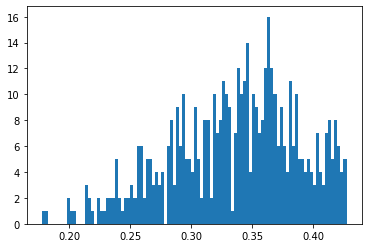

In [50]:
plt.hist(f1s, bins=100);

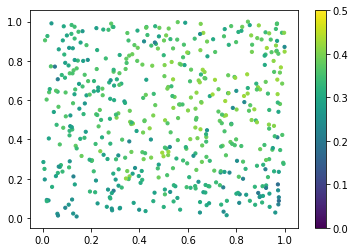

In [53]:
plt.scatter(ws[:, 0], ws[:, 1], s=10, c=f1s)
plt.colorbar()
plt.clim([0.0, 0.5])

## Naive

In [9]:
import numpy as np

In [10]:
naive_auc = 0.5
print(f'Naive ROC AUC = {naive_auc}')

Naive ROC AUC = 0.5


In [11]:
naive_acc = (test_y == np.zeros(test_y.shape[0])).mean()

print(f'Naive Accuracy = {naive_acc}')

Naive Accuracy = 0.554656155416344


# Adversarial MCMC sampler vs Random sampler

In [63]:
# path to MCMC output
output = pd.read_csv('../results_2/results.csv')
generated = output.generated_sequence.values
original = output.original.values

output_rand = pd.read_csv('../results_random/results.csv')
generated_rand = output_rand.generated_sequence.values
original_rand = output_rand.original.values

output_hotflip = pd.read_csv('hotflip_output.csv')
generated_hotflip = output_hotflip.generated_sequence.values
original_hotflip = output_hotflip.original.values

In [64]:
output.shape, output_rand.shape, output_hotflip.shape

((14207, 11), (14207, 11), (14207, 4))

In [65]:
def get_results(output, test_y, generated, original):
    num_generated_so_far = generated.shape[0]

    adversarial_probs = model.predict(generated)

    print(f'Average WER = {output.wer.mean()}\nAverage BLEU = {output.bleu.mean()}\n')
    print(f'Naive ROC AUC = {naive_auc}\nNaive Accuracy = {naive_acc}\n')

    non_adversarial_probs = model.predict(original)
    adv_auc = roc_auc_score(y_true=test_y[:num_generated_so_far], y_score=non_adversarial_probs[:, 1])
    print(f'Non-Adversarial ROC AUC = {adv_auc}')
    adv_acc = (test_y[:num_generated_so_far] == non_adversarial_probs.argmax(axis=1)).mean()
    print(f'Non-Adversarial Accuracy = {adv_acc}\n')

    adv_auc = roc_auc_score(y_true=test_y[:num_generated_so_far], y_score=adversarial_probs[:, 1])
    print(f'Adversarial ROC AUC = {adv_auc}')
    adv_acc = (test_y[:num_generated_so_far] == adversarial_probs.argmax(axis=1)).mean()
    print(f'Adversarial Accuracy = {adv_acc}')

In [66]:
print('>>> MCMC\n')
get_results(output, test_y, generated, original)

>>> MCMC

Average WER = 1.8081227563876963
Average BLEU = 0.8201734764653238

Naive ROC AUC = 0.5
Naive Accuracy = 0.554656155416344

Non-Adversarial ROC AUC = 0.7425382836750724
Non-Adversarial Accuracy = 0.6852959808545084

Adversarial ROC AUC = 0.6136349112938747
Adversarial Accuracy = 0.5886534806785387


In [67]:
print('>>> Random\n')
get_results(output_rand, test_y, generated_rand, original_rand)

>>> Random

Average WER = 1.4975012317871472
Average BLEU = 0.8514050227449653

Naive ROC AUC = 0.5
Naive Accuracy = 0.554656155416344

Non-Adversarial ROC AUC = 0.7425382836750724
Non-Adversarial Accuracy = 0.6852959808545084

Adversarial ROC AUC = 0.6678953766750988
Adversarial Accuracy = 0.6265221369747308


In [68]:
print('>>> Hotflip\n')
get_results(output_hotflip, test_y, generated_hotflip, original_hotflip)

>>> Hotflip

Average WER = 6.903357499824031
Average BLEU = 0.2775505447367772

Naive ROC AUC = 0.5
Naive Accuracy = 0.554656155416344

Non-Adversarial ROC AUC = 0.7425382836750724
Non-Adversarial Accuracy = 0.6852959808545084

Adversarial ROC AUC = 0.5762124032929536
Adversarial Accuracy = 0.60660237910889
